In [1]:
from sklearn.datasets import load_files
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.model_selection import cross_validate
from keras.utils import np_utils
from keras.preprocessing import image                  
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.layers import Activation, BatchNormalization, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def load_dataset(path):
    data = load_files(path)
    spectogram_files = np.array(data['filenames'])
    spectogram_targets = np.array(data['target'])
    return spectogram_files, spectogram_targets

In [3]:
train_files, train_targets = load_dataset('Data/train_spectograms/')

In [4]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [5]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255

100%|██████████| 2625/2625 [00:03<00:00, 740.66it/s]


In [6]:
learning_rate = 0.005
train_epochs=1

In [7]:
def cnn_model():
    # Define the network
    model = Sequential()

    model.add(Conv2D(16, 3, padding='same', use_bias=False, input_shape=(224, 224, 3)))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))

    model.add(Conv2D(32, 3, padding='same', use_bias=False))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))

    model.add(Conv2D(64, 3, padding='same', use_bias=False))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))

    model.add(Conv2D(128, 3, padding='same', use_bias=False))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.SGD(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
model = cnn_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
acti

In [9]:
neural_network = KerasClassifier(build_fn=cnn_model, epochs=train_epochs, batch_size=32, verbose=1)

In [10]:
scoring = {'accuracy': 'accuracy', 'recall': 'recall', 
           'precision': 'precision', 'f1': 'f1', 'mcc': make_scorer(matthews_corrcoef)}

In [11]:
cv_results = cross_validate(neural_network, train_tensors, train_targets, scoring=scoring)

/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1750/1750 [==============================] - 12s 7ms/step
Epoch 1/1
1750/1750 [==============================] - 12s 7ms/step
Epoch 1/1
1750/1750 [==============================] - 12s 7ms/step


In [12]:
cv_results

{'fit_time': array([49.35817695, 50.38987112, 49.83851504]),
 'score_time': array([30.31553912, 32.94750905, 29.88760114]),
 'test_accuracy': array([0.87542857, 0.85942857, 0.87771429]),
 'train_accuracy': array([0.88857143, 0.85885714, 0.89314286]),
 'test_recall': array([0.67875648, 0.86419753, 0.58823529]),
 'train_recall': array([0.69578313, 0.85123967, 0.63943662]),
 'test_precision': array([0.73595506, 0.58091286, 0.72992701]),
 'train_precision': array([0.71076923, 0.61553785, 0.79370629]),
 'test_f1': array([0.70619946, 0.69478908, 0.6514658 ]),
 'train_f1': array([0.70319635, 0.71445087, 0.70826833]),
 'test_mcc': array([0.62814722, 0.62822115, 0.58330431]),
 'train_mcc': array([0.63467101, 0.63836275, 0.6494203 ])}

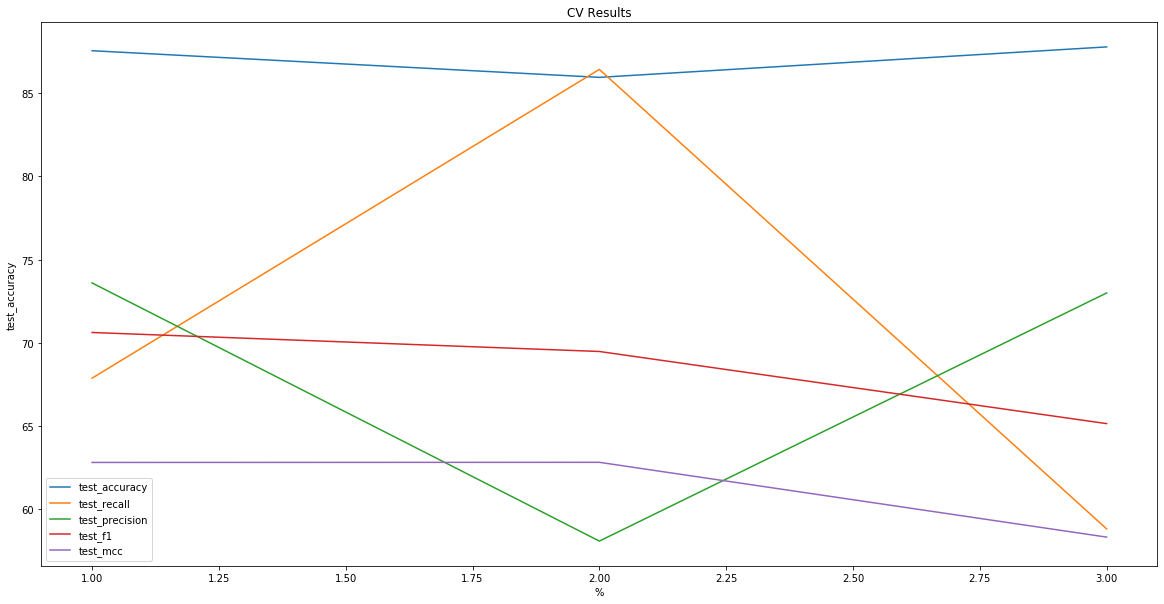

In [13]:
fig, ax1 = plt.subplots(figsize=(20, 10))
cv_folds = list(range(1, len(cv_results['fit_time']) + 1))
ax1.plot(cv_folds, cv_results['test_accuracy'] * 100)
ax1.plot(cv_folds, cv_results['test_recall'] * 100)
ax1.plot(cv_folds, cv_results['test_precision'] * 100)
ax1.plot(cv_folds, cv_results['test_f1'] * 100)
ax1.plot(cv_folds, cv_results['test_mcc'] * 100)
ax1.set(xlabel='%', ylabel='test_accuracy', title='CV Results')
ax1.legend(['test_accuracy', 'test_recall', 'test_precision', 'test_f1', 'test_mcc']);